## Chapter 5: Model Comparison

In [2]:
import numpy as np 
from scipy import stats
import pymc3 as pm
import arviz as az
import theano
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Text(0, 0.5, 'y')

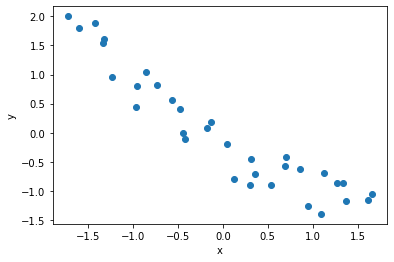

In [4]:
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]
order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / \
x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

Here we make a linear model and a quadratic model to fit the data

In [5]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + β * x_1s[0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_l = pm.sample(2000)
    
with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s) # fancy way of getting polynomials
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 69 seconds.


Next, we plot the most likely parameters from our two models

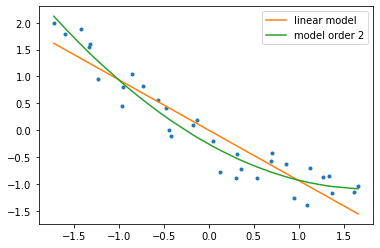

In [6]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)
α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post * x_new
plt.plot(x_new, y_l_post, 'C1', label='linear model')
α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)
plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')
α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p)
plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()

Next, we will do a posterior predictive check:

In [7]:
y_l = pm.sample_posterior_predictive(trace_l, 2000, model=model_l)['y_pred']
y_p = pm.sample_posterior_predictive(trace_p, 2000, model=model_p)['y_pred']

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


([], [])

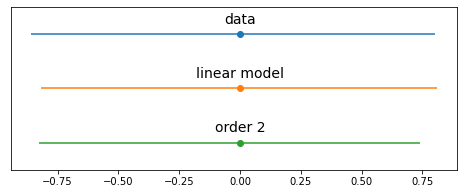

In [8]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

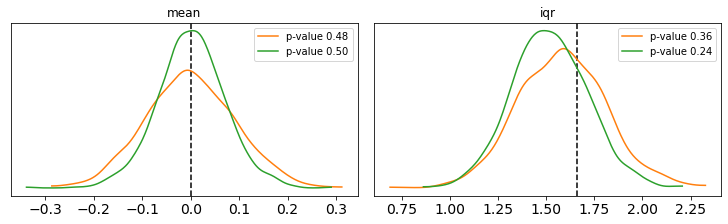

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))
for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c}, label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()

The dashed line is the computed statistics from the data. Here we also include something called $p-values$. These are *Bayesian p-values*. All they are is the total number of samples in our posterior distribution that are either on the actual mean or above the mean. This can be seen as a measure of bias in our model. We are aiming for something close to 0.5, as this would indicate that the uncertainty is symmetric around the measure we are trying to gauge. 

### The best and worst of the models


Text(0, 0.5, 'y')

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

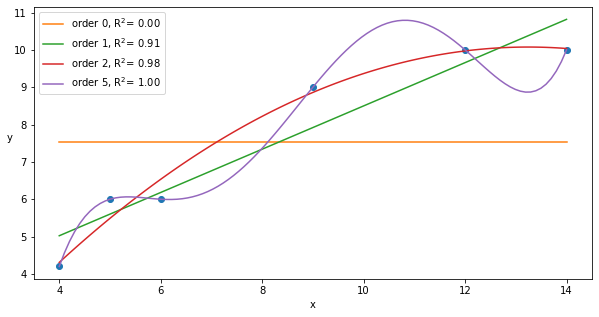

In [10]:
x = np.array([4., 5., 6., 9., 12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])
plt.figure(figsize=(10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')

for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')
    
plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [11]:
waic_l = az.waic(trace_l)
waic_l

Computed from 8000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -14.37     2.66
p_waic        2.45        -

NOTE: Looks nothing like thing that he gets out in the book :O 

In [12]:
cmp_df = az.compare({'model_l':trace_l, 'model_p':trace_p}, method='BB-pseudo-BMA')
cmp_df

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_p,0,-4.553788,2.628122,0.00000,0.999008,2.544106,0.000000,False,log
model_l,1,-14.397758,2.471687,9.84397,0.000992,2.281510,2.640453,False,log


<AxesSubplot:xlabel='Log'>

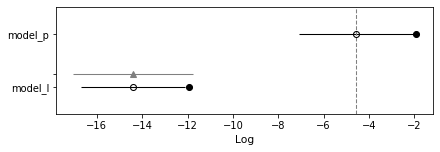

In [13]:
az.plot_compare(cmp_df)

## Meta models
When we are doing model comparison, we are essentially evaluating our models based on point estimates. That is to say, we are throwing away our uncertainty. This is somewhat mitigated in doing plots, where we can see whether there are overlapping distributions (see above). But another approach is to use all the uncertainty from different models, and weighting them in terms of their uncertainty. This mix of models is what is called a meta model. 

One way to calculate these weights are:

$$w_i = \frac{e^{\frac{1}{2}dE_i}}{\sum _j ^M e^{-\frac{1}{2}dE_j}}$$

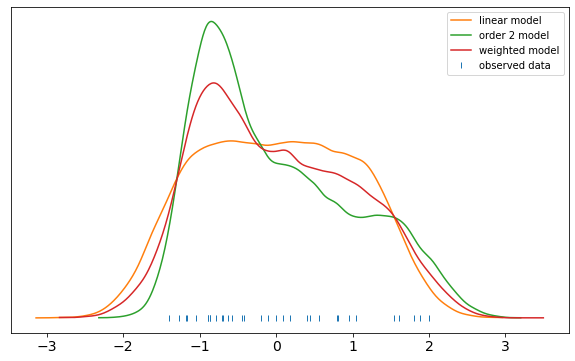

In [14]:
w = 0.5
y_lp = pm.sample_posterior_predictive_w([trace_l, trace_p],samples=1000,models=[model_l, model_p],weights=[w, 1-w])
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_l, plot_kwargs={'color': 'C1'},
label='linear model', ax=ax)
az.plot_kde(y_p, plot_kwargs={'color': 'C2'},
label='order 2 model', ax=ax)
az.plot_kde(y_lp['y_pred'], plot_kwargs={'color': 'C3'},
label='weighted model', ax=ax)
plt.plot(y_1s, np.zeros_like(y_1s), '|', label='observed data')
plt.yticks([])
plt.legend()

Above we are using the same weights for both models, but including both traces. So this is in essence just a stacking of both posteriors, where we combine each of the models into one. Using the same weights for both models is rather stupid, because we saw from our compare that the quadratic model outperformed the linear model by miles.

## Bayes Factor
To compare models, we can also just compute *Bayes Factor*. This is the ratio between the marginal likelihoods of two models:

$$BF = \frac{p(y|M_0)}{p(y|M_1)}$$

When $BF > 1$, model 0 better explains the data.

In [15]:
coins = 30
heads = 9
y_d = np.repeat([0, 1], [coins-heads, heads])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 66 seconds.


array([[<AxesSubplot:title={'center':'model_index'}>,
        <AxesSubplot:title={'center':'model_index'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

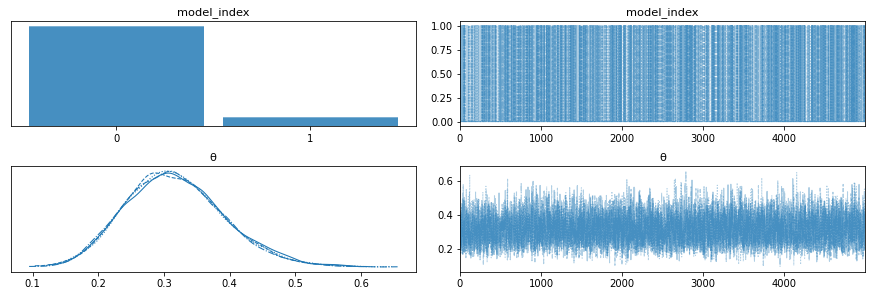

In [16]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1) #math switch to switch between models, based on equals (if-else)
    # a priori
    θ = pm.Beta('θ', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF = pm.sample(5000)
az.plot_trace(trace_BF)

In [17]:
pM1 = trace_BF['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])
BF

11.084592145015105

Getting a BF of more than 11 is support for the model 0, which has a prior skewing the distribution to fewer heads than tails. Another way of calculating BF is using sequential monte carlo sampling (SMC):

In [18]:
with pm.Model() as model_BF_0:
    θ = pm.Beta('θ', 4, 8)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_0 = pm.sample_smc(2500)
with pm.Model() as model_BF_1:
    θ = pm.Beta('θ', 8, 4)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_1 = pm.sample_smc(2500)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.203
Stage:   1 Beta: 0.663
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.209
Stage:   1 Beta: 0.679
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.211
Stage:   1 Beta: 0.688
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.205
Stage:   1 Beta: 0.679
Stage:   2 Beta: 1.000


In [19]:
az.summary(trace_BF_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.309,0.07,0.179,0.44,0.001,0.0,10144.0,10038.0,10205.0,10035.0,1.0


In [20]:
az.summary(trace_BF_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.404,0.074,0.263,0.54,0.001,0.001,9576.0,9571.0,9580.0,9581.0,1.0


##### Currently, these do not work in our version of PYMC3...

In [21]:
coins = 300
heads = 90
y_d = np.repeat([0, 1], [coins-heads, heads])

In [22]:
traces = []
waics = []
for coins, heads in [(30, 9), (300, 90)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4, 8), (8, 4)]:
        with pm.Model() as model:
            θ = pm.Beta('θ', *priors)
            y = pm.Bernoulli('y', θ, observed=y_d)
            trace = pm.sample(2000)
            traces.append(trace)
            waics.append(az.waic(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.
The acceptance probability does not match the target. It is 0.8810301014473491, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

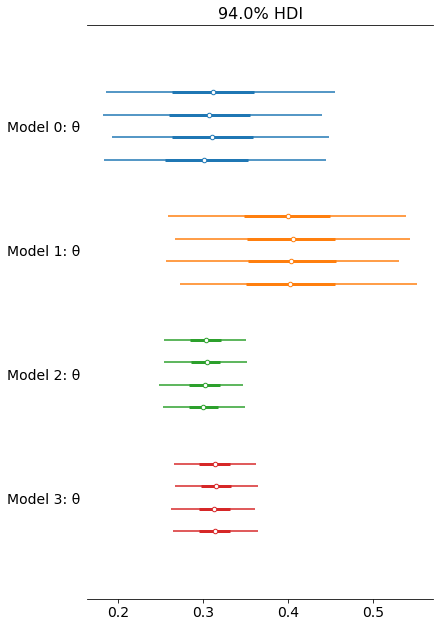

In [23]:
az.plot_forest(traces, combined=False, colors='cycle')
#y_lims = axes[0].get_ylim()
#axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)

## Entropomorphizing

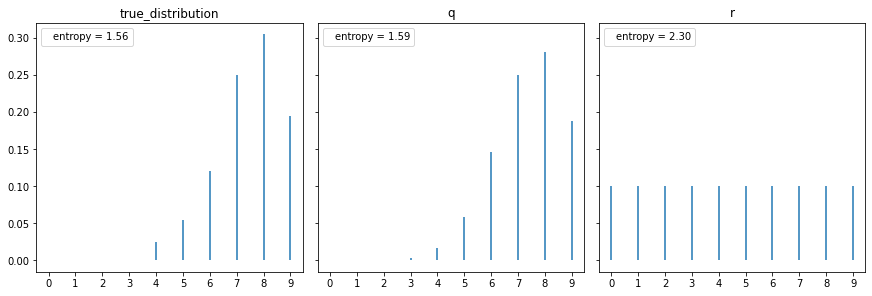

In [24]:
np.random.seed(912)
x = range(0, 10)
q = stats.binom(10, 0.75)
r = stats.randint(0, 10)
true_distribution = [list(q.rvs(200)).count(i) / 200 for i in x]
q_pmf = q.pmf(x)
r_pmf = r.pmf(x)
_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, constrained_layout=True)
for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf],
['true_distribution', 'q', 'r'])):
    ax[idx].vlines(x, 0, dist, label=f'entropy = {stats.entropy(dist):.2f}')
    ax[idx].set_title(label)
    ax[idx].set_xticks(x)
    ax[idx].legend(loc=2, handlelength=0)

### KL Divergence

In [25]:
stats.entropy(true_distribution, q_pmf), stats.entropy(true_distribution,
r_pmf)

(0.009657896086383405, 0.7394593875511319)

More support for "q", as "r" introduces more uncertainty.

## Exercises:
### Exercise 1:
This exercise is about regularization priors. In the code that generates the data,
change order=2 to another value, such as order=5. Then, fit model_p and plot
the resulting curve. Repeat this, but now using a prior for beta with sd=100
instead of sd=1 and plot the resulting curve. How are both curves different? Try
this out with sd=np.array([10, 0.1, 0.1, 0.1, 0.1]), too.

Text(0, 0.5, 'y')

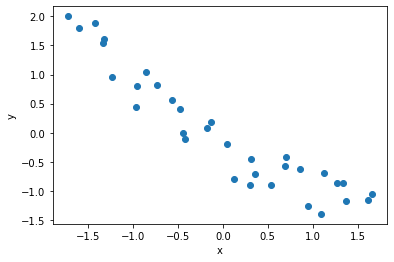

In [26]:
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]
order = 5
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / \
x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

In [27]:
with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s) # fancy way of getting polynomials
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_p = pm.sample(2000)
    
with pm.Model() as model_p_s:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=100, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s) # fancy way of getting polynomials
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_p_s = pm.sample(2000)
    
sd_array = np.array([10, 0.1, 0.1, 0.1, 0.1])
    
with pm.Model() as model_sd:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=sd_array, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s) # fancy way of getting polynomials
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_sd = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 159 seconds.
There were 539 divergences after tuning. Increase `target_accept` or reparameterize.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 204 seconds.
There were 895 divergences after tuning. Increase `target_accept` or reparameterize.
There were 651 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 518 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


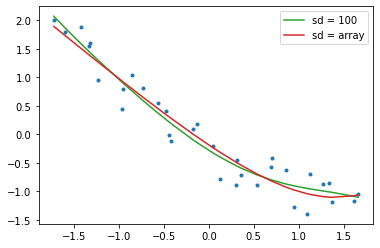

In [28]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)
x_new_p = np.vstack([x_new**i for i in range(1, order+1)]) #stack to make dot-product with all 5 beta values
#α_l_post = trace_p['α'].mean()
#β_l_post = trace_p['β'].mean(axis=0)
#y_l_post = α_l_post + np.dot(β_l_post, x_new_p) #dot product - wrong x???
#plt.plot(x_new, y_l_post, 'C1', label='sd = 10')
α_p_post = trace_p_s['α'].mean()
β_p_post = trace_p_s['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)
plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label="sd = 100")
α_p_sd = trace_sd['α'].mean()
β_p_sd = trace_sd['β'].mean(axis=0)
y_p_sd = α_p_sd + np.dot(β_p_sd, x_1s)
plt.plot(x_1s[0][idx], y_p_sd[idx], 'C3', label="sd = array") #NOTE: This is much like ridge regression, where we penalize larger values. NOTE: ZERO DIVERGENCES!!
#α_p_post = trace_p_s['α'].mean()
#β_p_post = trace_p_s['β'].mean(axis=0)
#y_p_post = α_p_post + np.dot(β_p_post, x_new_p)
plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()

The ridge regression was the best - no divergences, just amazing.

## Exercise 2: More is More

Repeat the previous exercise but increase the amount of data to 500 data points. NOTE: What the hell? Skipping this for now, want to do something else than just simulating data.

### Exercise 3: Cubic

Text(0, 0.5, 'y')

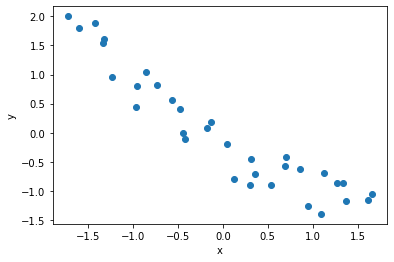

In [29]:
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]
order = 3
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / \
x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

In [30]:
x_1s[0:2]

array([[-1.72414181, -1.5947931 , -1.41718994, -1.32135125, -1.33810627,
        -1.23087417, -0.96480453, -0.95877273, -0.85556184, -0.73492573,
        -0.56871598, -0.41591024, -0.4795793 , -0.44137787, -0.17932943,
        -0.12839419,  0.04786857,  0.11890983,  0.31862961,  0.3072362 ,
         0.36085225,  0.5310832 ,  0.69863335,  0.69662275,  0.85344969,
         0.95263938,  1.12354053,  1.0907007 ,  1.26897406,  1.33800472,
         1.37151475,  1.61412737,  1.66104141],
       [-0.6811725 , -0.76003053, -0.84312138, -0.87585202, -0.87074204,
        -0.89896365, -0.92310164, -0.9228906 , -0.91407052, -0.89128571,
        -0.83786718, -0.76623575, -0.7987041 , -0.77967256, -0.61277348,
        -0.57296772, -0.41671773, -0.34562583, -0.12078093, -0.13459894,
        -0.06852717,  0.15885519,  0.40880321,  0.40565007,  0.66281204,
         0.83719337,  1.15897266,  1.09504594,  1.45405472,  1.6009563 ,
         1.67385522,  2.23259249,  2.34691077]])

In [31]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + β * x_1s[0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_l = pm.sample(2000)
    
with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order-1)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s[0:2]) # fancy way of getting polynomials
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_p = pm.sample(2000)    

with pm.Model() as model_q:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s) # fancy way of getting polynomials
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_q = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 70 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8904879452355833, but should be close to 0.8. Try to increase the number of tuning steps.


In [32]:
traces = (trace_l, trace_q, trace_p)
for i in traces:
    waics = az.waic(i)
    print(waics)

Computed from 8000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -14.44     2.67
p_waic        2.51        -
Computed from 8000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic    -5.44     2.31
p_waic        3.30        -
Computed from 8000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic    -4.61     2.36
p_waic        2.70        -


In [33]:
cmp_df = az.compare({'model_l':trace_l, 'model_p':trace_p, "model_q":trace_q}, method='BB-pseudo-BMA')
cmp_df

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_p,0,-4.642604,2.725673,0.000000,0.700142,2.290255,0.000000,False,log
model_q,1,-5.503705,3.359174,0.861101,0.298945,2.650431,0.356722,False,log
model_l,2,-14.477120,2.546546,9.834517,0.000913,2.332046,2.666361,False,log


<AxesSubplot:xlabel='Log'>

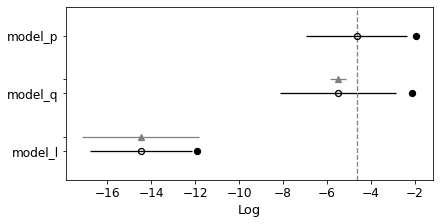

In [34]:
az.plot_compare(cmp_df)

## Exercise 4: The posterior of y
Use pm.sample_posterior_predictive() to rerun the PPC example, but this
time, plot the values of y instead of the values of the mean.

In [35]:
az.summary(trace_q)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.000,0.049,-0.091,0.093,0.001,0.001,4616.0,3141.0,4618.0,4329.0,1.0
β[0],-1.433,0.135,-1.681,-1.171,0.002,0.002,3380.0,3380.0,3368.0,4393.0,1.0
β[1],0.434,0.406,-0.315,1.200,0.008,0.006,2325.0,2325.0,2317.0,3154.0,1.0
β[2],0.114,0.333,-0.473,0.773,0.007,0.005,2413.0,2352.0,2411.0,3382.0,1.0
ϵ,0.277,0.038,0.213,0.351,0.001,0.001,2510.0,2510.0,2290.0,1994.0,1.0


In [36]:
y_l = pm.sample_posterior_predictive(trace_l, 2000, model=model_l, var_names = ["y_pred"])
y_p = pm.sample_posterior_predictive(trace_p, 2000, model=model_p, var_names = ["y_pred"])
#y_q = pm.sample_posterior_predictive(trace_q, 2000, model=model_p, var_names = ["y_pred"])

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [39]:
print(type(y_l))
print(type(model_l))

<class 'dict'>
<class 'pymc3.model.Model'>


<AxesSubplot:xlabel='y_pred'>

C:\Users\Mikkel\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


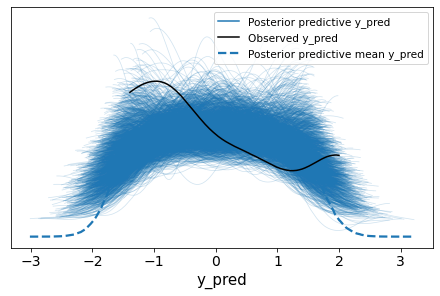

In [37]:
az.plot_ppc(az.from_pymc3(posterior_predictive = y_l, model = model_l))

<AxesSubplot:xlabel='y_pred'>

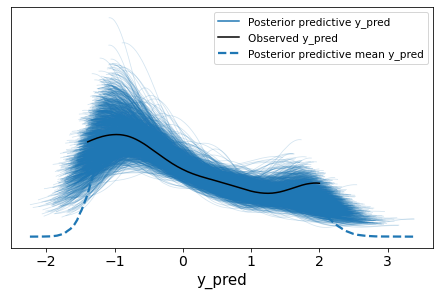

In [38]:
az.plot_ppc(az.from_pymc3(posterior_predictive = y_p, model = model_p))

So we can also see that the second model is way better in our posterior predictive check.

## Exercise 5: Run through a notebook
Read and run the posterior predictive example from PyMC3's documentation at
https:/​/​pymc-​devs.​github.​io/​pymc3/​notebooks/​posterior_​predictive.​html.
Pay special attention to the use of the Theano shared variables

In [87]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from scipy.special import expit as logistic

RANDOM_SEED = 58

In [88]:
az.style.use("arviz-darkgrid")


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [89]:
N = 100

true_a, true_b, predictor = 0.5, 3.0, np.random.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * predictor
true_sd = 2.0

outcome = np.random.normal(loc=true_mu, scale=true_sd, size=N)

f"{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}"

'2.39, 6.24, 8.25, 18.85'

Solid. Doesn't specify random seed anywhere, so this won't generalize. Great stuff. We'll see what happens. Let's use their standardize function to get moving.

In [90]:
predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)

f"{predictor_scaled.mean():.2f}, {predictor_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}"

'0.00, 1.00, 0.00, 1.00'

In [91]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * predictor_scaled
    sd = pm.Exponential("sd", 1.0)

    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=outcome_scaled)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

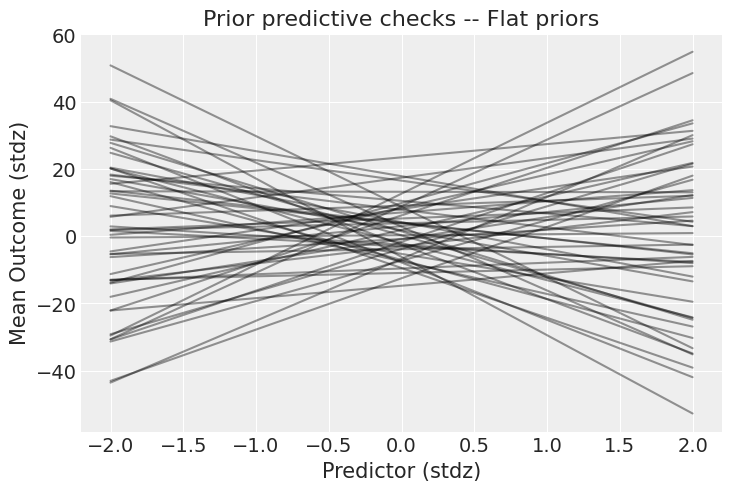

In [92]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["b"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

In [93]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * predictor_scaled
    sd = pm.Exponential("sd", 1.0)

    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=outcome_scaled)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

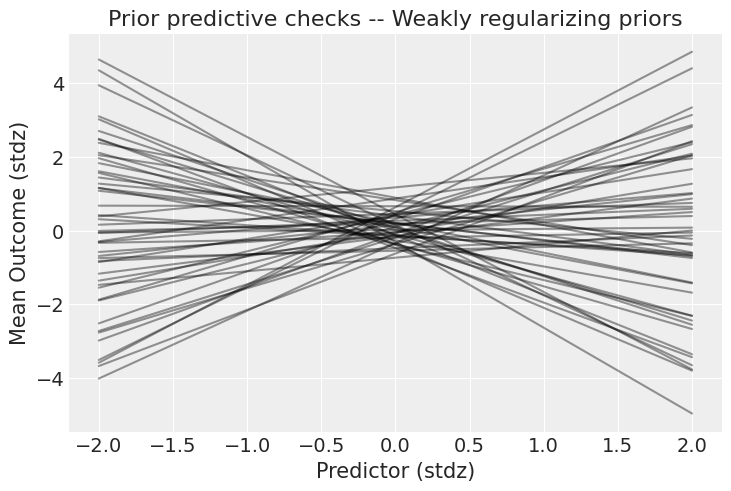

In [94]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["b"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 36 seconds.


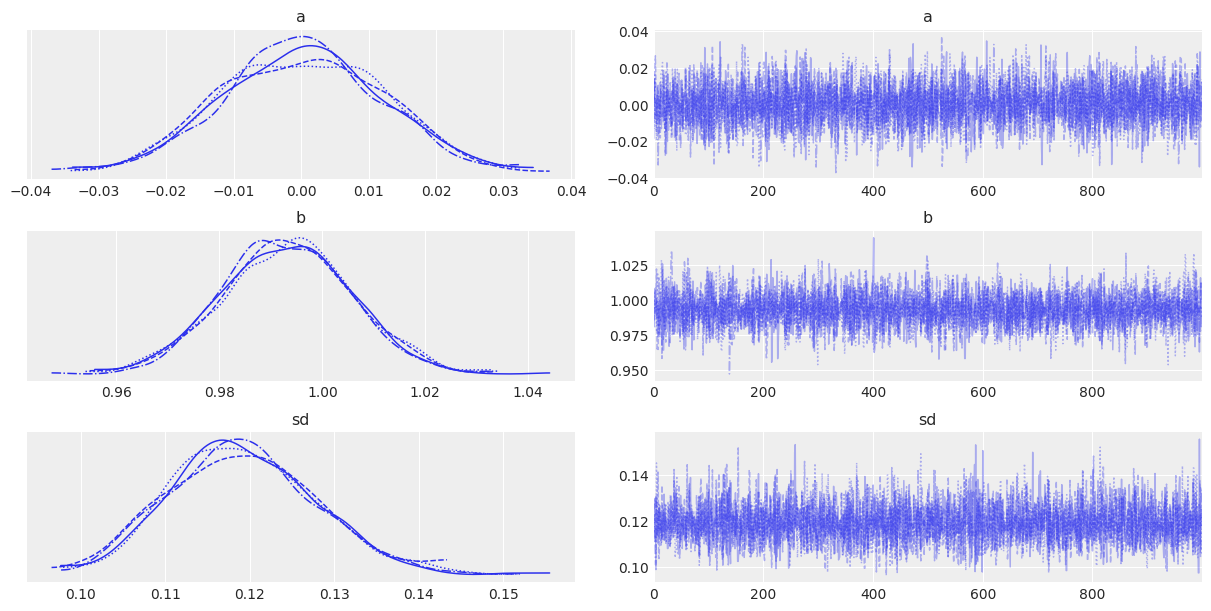

In [95]:
with model_1:
    trace_1 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, return_inferencedata=True)
az.plot_trace(trace_1);

In [96]:
with model_1:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=["a", "b", "obs"], random_seed=RANDOM_SEED
    )
ppc["obs"].shape

(4000, 100)

C:\Users\Mikkel\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


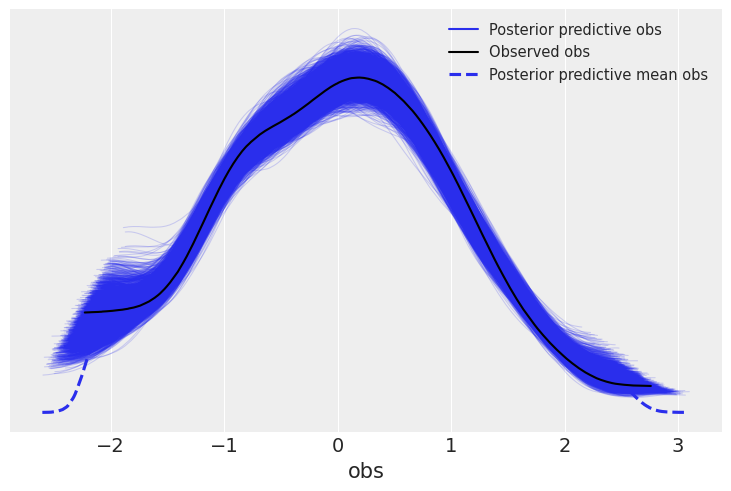

In [97]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_1));

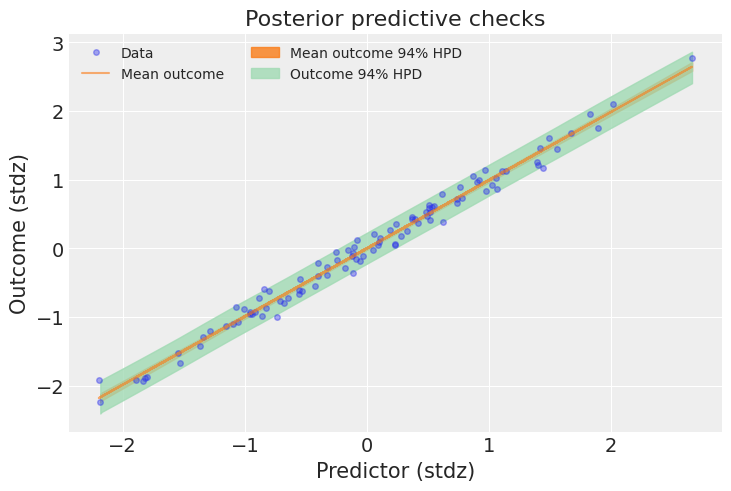

In [98]:
mu_pp = (ppc["a"] + ppc["b"] * predictor_scaled[:, None]).T

_, ax = plt.subplots()

ax.plot(predictor_scaled, outcome_scaled, "o", ms=4, alpha=0.4, label="Data")
ax.plot(predictor_scaled, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
az.plot_hpd(
    predictor_scaled,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
az.plot_hpd(
    predictor_scaled,
    ppc["obs"],
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HPD"},
)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);

In [99]:
N = 400
true_intercept = 0.2
true_slope = 1.0
predictors = np.random.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = np.random.binomial(1, true_p)
outcomes[:10]

array([1, 1, 0, 1, 1, 1, 1, 0, 0, 1])

In [100]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.Data("pred", predictors)
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred))

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes)

    trace_2 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, return_inferencedata=True)
az.summary(trace_2, var_names=["betas"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 43 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],0.24,0.11,0.05,0.45,0.0,0.0,3283.48,3135.74,3294.70,2836.18,1.0
betas[1],1.08,0.14,0.84,1.35,0.0,0.0,3166.22,3065.49,3171.02,2628.00,1.0


In [101]:
predictors_out_of_sample = np.random.normal(size=50)
outcomes_out_of_sample = np.random.binomial(
    1, logistic(true_intercept + true_slope * predictors_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace_2, var_names=["p"], random_seed=RANDOM_SEED
    )
    model_preds = posterior_predictive["p"]

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(


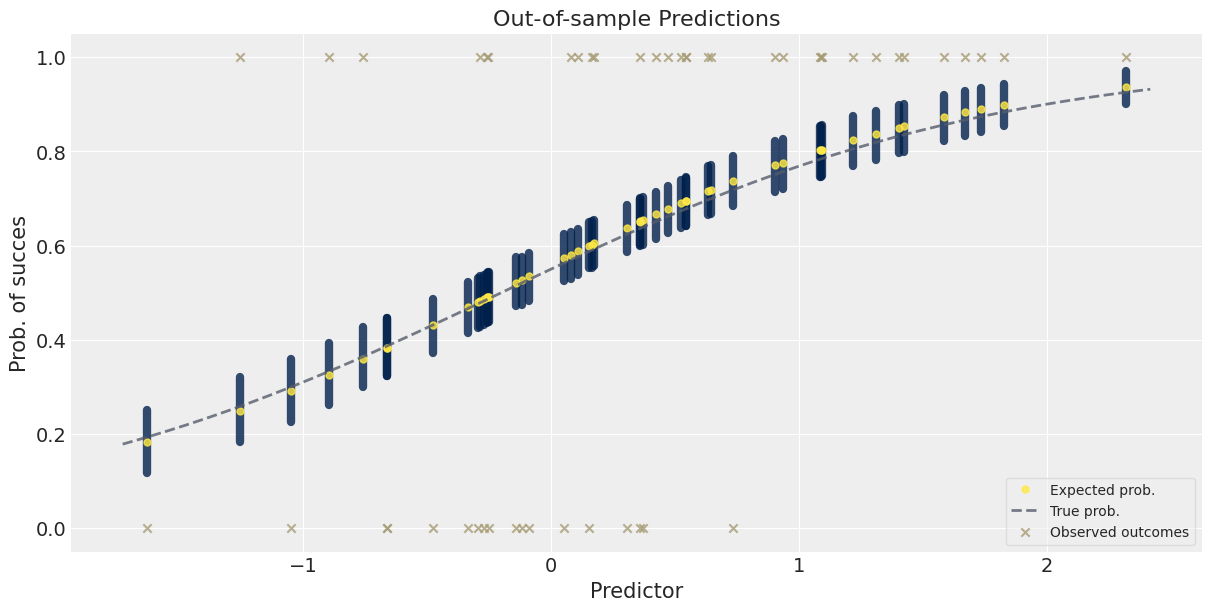

In [102]:
_, ax = plt.subplots(figsize=(12, 6))

# uncertainty about the estimates:
ax.plot(
    [predictors_out_of_sample, predictors_out_of_sample],
    az.hpd(model_preds).T,
    lw=6,
    color="#00204C",
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    predictors_out_of_sample,
    model_preds.mean(0),
    "o",
    ms=5,
    color="#FFE945",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker="x",
    color="#A69C75",
    alpha=0.8,
    label="Observed outcomes",
)

# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of succes")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

Take aways: The plots are really cool. But I didn't really see any shared variables... Maybe I am blind :D 

## Exercise 6: 6 Data Points
Go back to the code that generated Figure 5.5 and Figure 5.6, and modify it to get
new sets of six data points. Visually evaluate how the different polynomials fit
these new datasets. Relate the results to the discussions in this book.

Text(0, 0.5, 'y')

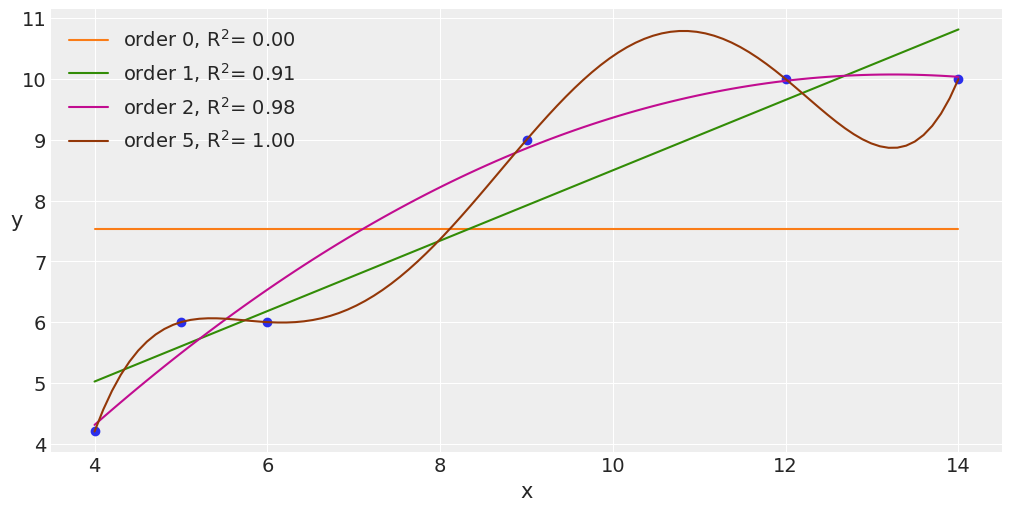

In [103]:
x = np.array([4., 5., 6., 9., 12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])
plt.figure(figsize=(10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')

for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')
    
plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

Text(0, 0.5, 'y')

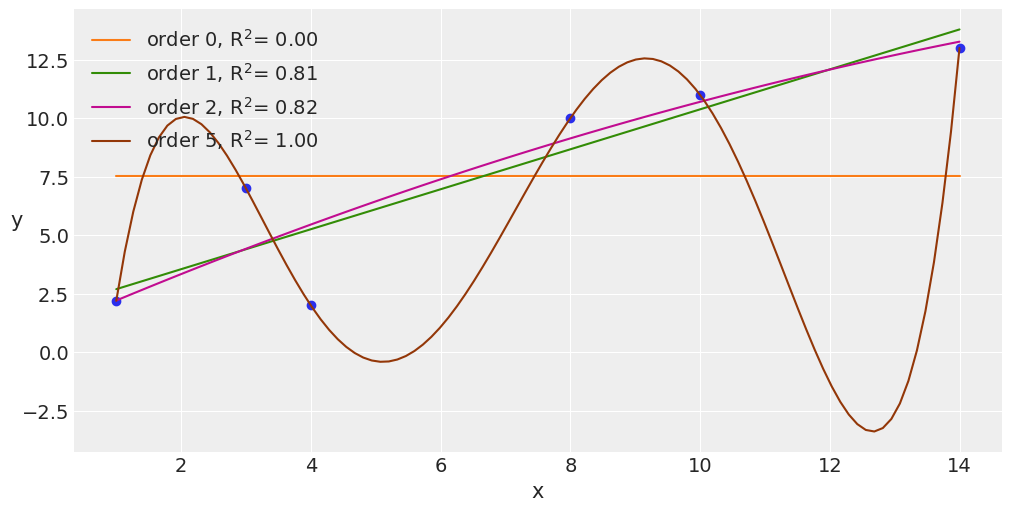

In [106]:
x = np.array([1., 3., 4., 8., 10, 14.])
y = np.array([2.2, 7., 2., 10., 11, 13.])
plt.figure(figsize=(10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')

for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')
    
plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

Extreme overfitting in order 5, as we have enough parameters to perfectly match everything. Surprisingly for these stupid data points, 1 and second order are very close to each other, which is quite surprising. 

## Exercise 7: Another Notebook
Read and run the model averaging example from PyMC3's documentation at
https:/​/​docs.​pymc.​io/​notebooks/​model_​averaging.​html

In [107]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [108]:
d = pd.read_csv(
    "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking_2/Data/milk.csv",
    sep=";",
)
d = d[["kcal.per.g", "neocortex.perc", "mass"]].rename({"neocortex.perc": "neocortex"}, axis=1)
d["log_mass"] = np.log(d["mass"])
d = d[~d.isna().any(axis=1)].drop("mass", axis=1)
d.iloc[:, 1:] = d.iloc[:, 1:] - d.iloc[:, 1:].mean()
d.head()

,kcal.per.g,neocortex,log_mass
0,0.49,-12.415882,-0.831486
5,0.47,-3.035882,0.158913
6,0.56,-3.035882,0.181513
7,0.89,0.064118,-0.579032
9,0.92,1.274118,-1.884978


In [109]:
with pm.Model() as model_0:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", 10)

    mu = alpha + beta * d["neocortex"]

    kcal = pm.Normal("kcal", mu=mu, sigma=sigma, observed=d["kcal.per.g"])
    trace_0 = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.


In [110]:
with pm.Model() as model_1:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", 10)

    mu = alpha + beta * d["log_mass"]

    kcal = pm.Normal("kcal", mu=mu, sigma=sigma, observed=d["kcal.per.g"])

    trace_1 = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.


In [111]:
with pm.Model() as model_2:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal("sigma", 10)

    mu = alpha + pm.math.dot(beta, d[["neocortex", "log_mass"]].T)

    kcal = pm.Normal("kcal", mu=mu, sigma=sigma, observed=d["kcal.per.g"])

    trace_2 = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.


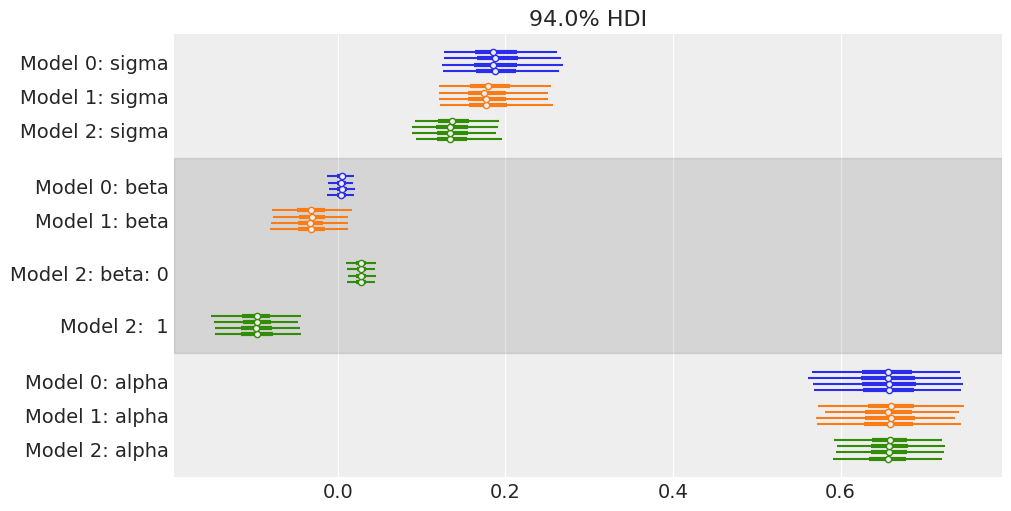

In [112]:
traces = [trace_0, trace_1, trace_2]
az.plot_forest(traces, figsize=(10, 5));

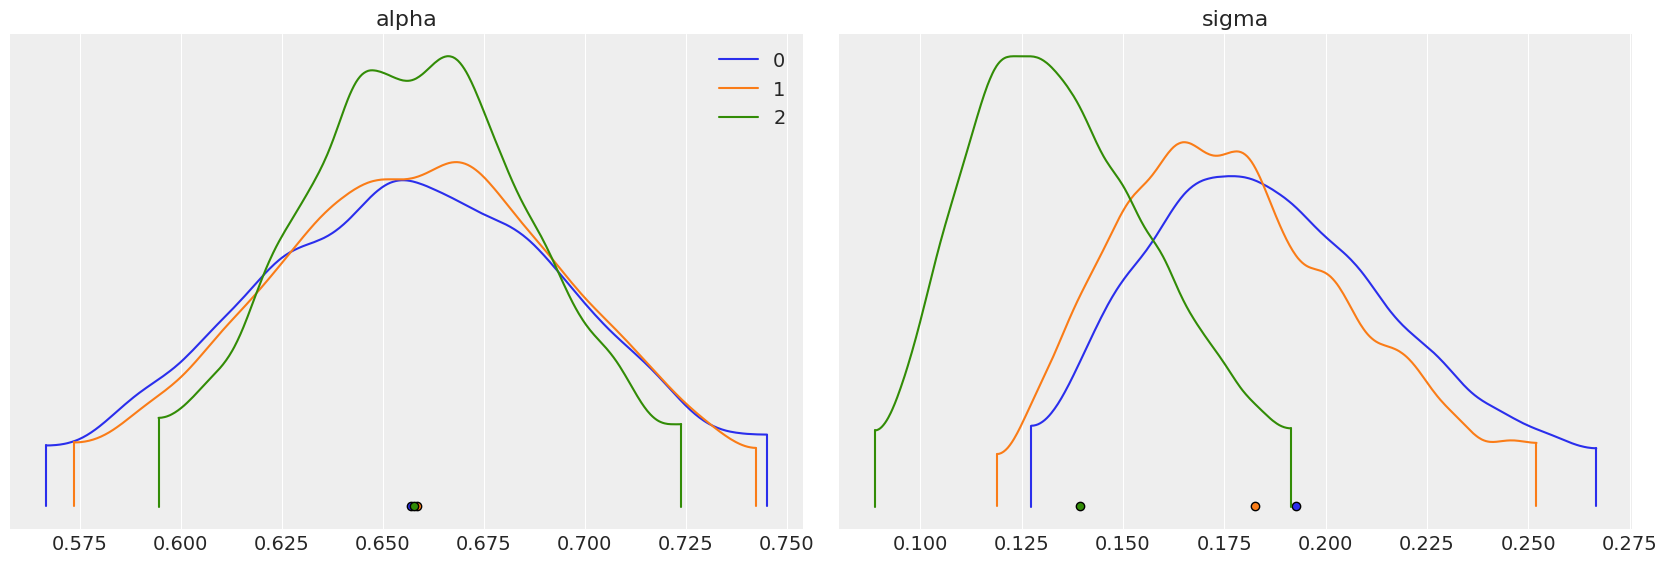

In [113]:
az.plot_density(traces, var_names=["alpha", "sigma"]);

In [114]:
model_dict = dict(zip(["model_0", "model_1", "model_2"], traces))
comp = az.compare(model_dict)
comp

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_2,0,8.266546,3.262908,0.000000,1.000000e+00,2.555402,0.000000,False,log
model_1,1,4.403625,2.067384,3.862922,0.000000e+00,2.055313,1.749012,False,log
model_0,2,3.467754,2.052555,4.798792,1.576517e-14,1.603784,2.526139,False,log


In [115]:
ppc_w = pm.sample_posterior_predictive_w(
    traces,
    1000,
    [model_0, model_1, model_2],
    weights=comp.weight.sort_index(ascending=True),
    progressbar=True,
)

In [116]:
ppc_2 = pm.sample_posterior_predictive(trace_2, 1000, model_2, progressbar=False)

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


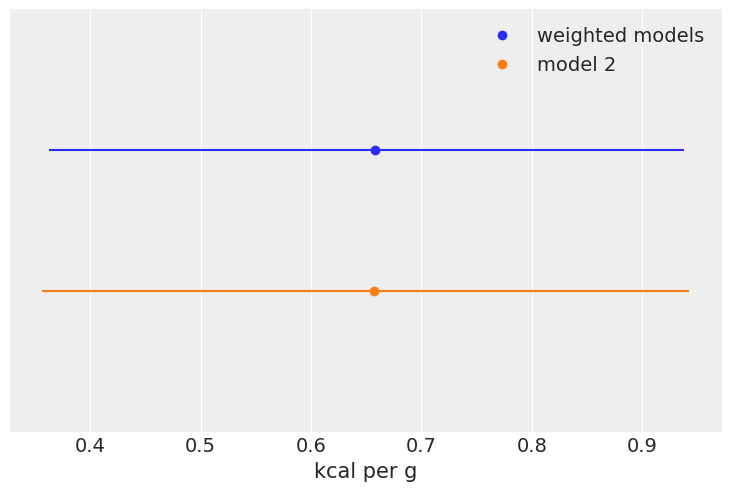

In [117]:
mean_w = ppc_w["kcal"].mean()
hpd_w = az.hdi(ppc_w["kcal"]).mean(0)

mean = ppc_2["kcal"].mean()
hpd = az.hdi(ppc_2["kcal"]).mean(0)

plt.plot(mean_w, 1, "C0o", label="weighted models")
plt.hlines(1, *hpd_w, "C0")
plt.plot(mean, 0, "C1o", label="model 2")
plt.hlines(0, *hpd, "C1")

plt.yticks([])
plt.ylim(-1, 2)
plt.xlabel("kcal per g")
plt.legend();

## Exercise 8: Bayes Factor
Compute the Bayes factor for the coin problem using a uniform prior beta (1, 1)
and priors such as beta (0.5, 0.5). Set 15 heads and 30 coins. Compare this result
with the inference we got in the first chapter of this book

In [40]:
coins = 30
heads = 15
y_d = np.repeat([0, 1], [coins-heads, heads])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 79 seconds.


array([[<AxesSubplot:title={'center':'model_index'}>,
        <AxesSubplot:title={'center':'model_index'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

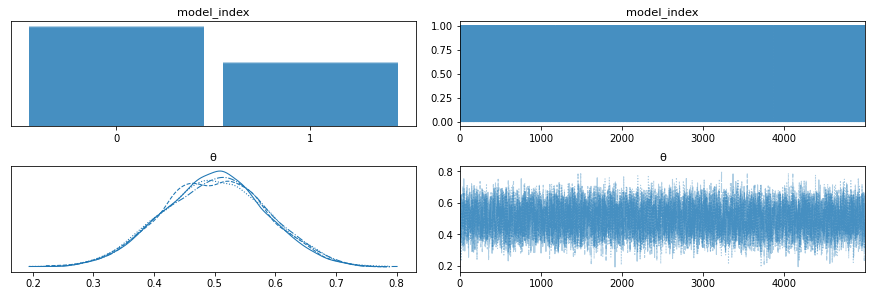

In [41]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    m_0 = (1, 1)
    m_1 = (.5, .5)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1) #math switch to switch between models, based on equals (if-else)
    # a priori
    θ = pm.Beta('θ', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF = pm.sample(5000)
az.plot_trace(trace_BF)

In [42]:
pM1 = trace_BF['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])
BF

1.5673940949935816

Was that it? I guess we should expect something very close to 1. So probably great. However, where do those priors come in? Doesn't really seem to be clear.